# Machine Learning Project - Part A : Airbnb Price Prediction and Insights

### Link to Video [here](https://drive.google.com/file/d/1H0xzewCHnFEJr4EB-x-ihNwmwvZIyNF_/view?usp=sharing)

## 1. Data Exploration and Preprocessing

### Importing dataset, checking for missing values and data cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import gc 
import ast

In [ ]:
# getting excel file path
filepath = 'E:\Online_Course\Machine Learning\Projects\Airbnb_data.xlsx'
data = pd.read_excel(filepath)

#finding the number of missing values in each column
missing_values = data.isnull().sum()
print('Variable          Missing Values')
print(missing_values[missing_values > 0])

#correcting missing values
imputer = SimpleImputer(strategy='mean')
data['bathrooms'] = imputer.fit_transform(data[['bathrooms']])
print('Filled missing values')

#dropping rows with missing values
data.dropna(subset=['bedrooms', 'beds'], inplace=True)
print('Dropped rows with missing data')

#normalizing values in certain rows
scaler = StandardScaler()
numerical_features = ['accommodates', 'bathrooms', 'latitude', 'longitude']
data[numerical_features] = scaler.fit_transform(data[numerical_features])
print('Normalized values in columns of accomdates, bathrooms, latitude and longitude')

#printing info to double check the output
print(data.info())

Variable          Missing Values
bathrooms                   200
description                   6
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
last_review               15827
name                         10
neighbourhood              6872
review_scores_rating      16722
thumbnail_url              8216
zipcode                     968
bedrooms                     91
beds                        131
dtype: int64
Filled missing values
Dropped rows with missing data
Normalized values in columns of accomdates, bathrooms, latitude and longitude
<class 'pandas.core.frame.DataFrame'>
Index: 73918 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      73918 non-null  int64  
 1   log_price               73918 non-null  float64
 2   property_type         

### Trend Analysis

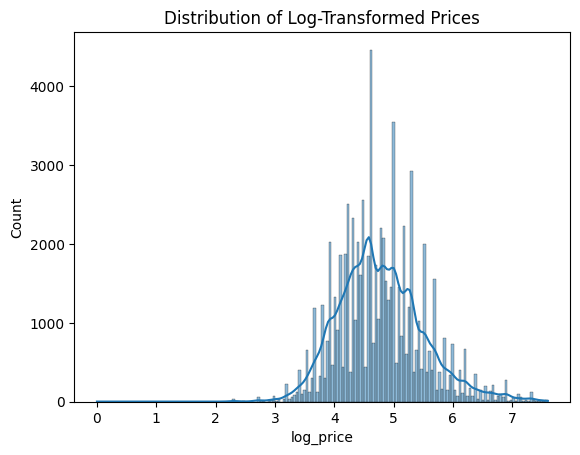

In [12]:
sns.histplot(data['log_price'], kde=True)
plt.title('Distribution of Log-Transformed Prices')
plt.show()

### Outlier Identification

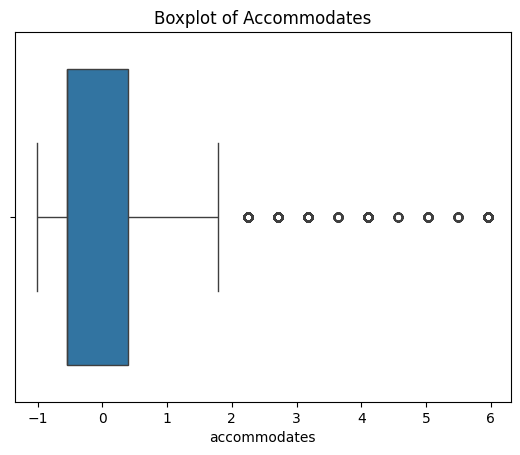

In [13]:
sns.boxplot(x=data['accommodates'])
plt.title('Boxplot of Accommodates')
plt.show()

### Creating a review age feature
The difference between the first and latest review

In [14]:
data['last_review'] = pd.to_datetime(data['last_review'], dayfirst=True)
data['first_review'] = pd.to_datetime(data['first_review'], dayfirst=True)
data['review_age'] = (data['last_review'] - data['first_review']).dt.days
print(data[['last_review', 'first_review', 'review_age']].head())



  last_review first_review  review_age
0  2016-07-18   2016-06-18        30.0
1  2017-09-23   2017-05-08       138.0
2  2017-09-14   2017-04-30       137.0
3         NaT          NaT         NaN
4  2017-01-22   2015-12-05       414.0


### Prepping and transforming data

In [ ]:
# creating a tempoary copy of the data
temp_data = data.copy()

# function to check if a string can be a python literal
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return [] 

# One-hot encoding for amenities
temp_data['amenities'] = temp_data['amenities'].apply(safe_literal_eval)
mlb = MultiLabelBinarizer()
amenities_encoded = pd.DataFrame(mlb.fit_transform(temp_data['amenities']), columns=mlb.classes_, index=temp_data.index)
temp_data = pd.concat([temp_data, amenities_encoded], axis=1)
temp_data.drop('amenities', axis=1, inplace=True)
del amenities_encoded
gc.collect()

# One-hot encode other categorical features
categorical_features = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city', 
                        'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
temp_data = pd.get_dummies(temp_data, columns=categorical_features)

# Drop unnecessary columns 
columns_to_drop = ['id', 'description', 'first_review', 'last_review', 'host_since', 'name', 'thumbnail_url', 'zipcode', 'neighbourhood']
temp_data = temp_data.drop(columns=columns_to_drop)
del categorical_features
gc.collect()

# Fill missing values
imputer = SimpleImputer(strategy='mean')
temp_data = pd.DataFrame(imputer.fit_transform(temp_data), columns=temp_data.columns)
del imputer
gc.collect()

0

## Model development
### Building a regression model to predict the listing prices prices

In [ ]:
# Model training
X = temp_data.drop('log_price', axis=1)
y = temp_data['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
mae = round(mean_absolute_error(y_test, y_pred),3)
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
r2 = round(r2_score(y_test, y_pred),3)

# Printing Evaluation
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')


MAE: 0.345
RMSE: 0.462
R-squared: 0.585


## **Summary of Evaluation**
### **Metrics**

<style>
p {
  line-height: 0.7;
  text-indent: 20px;
}
</style>


<ul>
<b><li> Mean Absolute Error (MAE)  :</li></b>
<p> On average, your model's predictions are off by about 0.346 units in the log-transformed price. </p>
<b> <li> Root Mean Squared Error (RMSE)  : </li></b>
<p> This value indicates that the average difference between the predicted and actual prices is around 0.463 units. </p>
<b><li> R-squared (R²) :</li> </b>
<p> Your model explains approximately 58.3% of the variance in the listing prices. This means that a bit more than half of the factors affecting price are captured by your model. </p>
</ul>

### **Insights**
<ol>
<b><li> Property Type: </li></b>
<p > Larger, exclusive properties command higher prices. </p>
<p > Room Type: Entire homes, private rooms, or shared rooms can affect prices. </p>
<p > Bed Type: Larger, more comfortable beds often lead to higher prices. </p>
<b><li> Cancellation Policy: </li></b>
<p > Listings with flexible cancellation policies attract more bookings and potentially higher prices. </p>
<b><li> City and Neighborhood: </li></b>
<p > Listings in popular, central, or upscale areas generally have higher prices. </p>
<b><li> Host Attributes:</li></b>
<p > Profile picture, verified identity, and response rate can impact price. </p>
<b><li> Instant Bookable: </li></b>
<p > Properties allowing instant booking attract more guests and command higher prices. </p>
<b><li> Amenities: </li></b>
<p >  Presence of amenities like Wi-Fi, air conditioning, kitchen, and parking can affect pricing. </p>
<b><li> Review Scores and Number of Reviews: </li></b>
<p > Higher review scores and a larger number of reviews enhance a listing's reputation. </p>
<b><li> Accommodation Features: </li></b>
<p > Number of accommodates, bathrooms, bedrooms, and beds can influence pricing. </p>
</ol>

### **Predictions for future listings**

<b> <div> Informed Decision-Making: </b> </div>
<p> Hosts set competitive prices based on model predictions. </p>
<b> Optimization: </b>
<p> Hosts can increase listing prices by tweaking features. </p>
<b> Market Insights: </b>
<p> The model can be used again, if and when needed to identify impactful features for prioritizing improvements.</p>